# 1. About the dataset

This dataset was downloaded from NEU Metal Surface Defects Databse which contains six kinds of typical surface defects of the hot-rolled steel strip are collected, i.e., rolled-in scale (RS), patches (Pa), crazing (Cr), pitted surface (PS), inclusion (In) and scratches (Sc). The database includes 1,800 grayscale images: 300 samples each of six different kinds of typical surface defects. The detailed defects are as follows:


*   **Inclusion**: Inclusion is a typical defect of metal surface defects. Some inclusions are loose and easy to fall off, some pressed into the plate.
*   **Crazing**: Crazing is the phenomenon that produces some cracks on the surface of a material.
*   **Patches**: A part of metal marked out from the rest by a particular characteristic.
*   **Pitted surface**: Pitting is a form of corrosion that focuses on a very small range of metal surfaces and penetrates into the metal interior. Pitting is generally small in diameter but deep in depth.
*   **Scratches**: A scratch is a mark of abrasion on a surface.
*   **Rolled in scale**: A rolled-in scale defect occurs when the mill scale is rolled into the metal duringthe rolling process.

The dataset divided into 3 directories. The training directory contains 276 images of each class from the 300 images. The rest 24 images of each class also divided into tests and valid datasets.



# 2. Import Library

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.datasets import load_files

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.preprocessing.image import array_to_img, img_to_array, load_img

In [2]:
train_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train'
val_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid'
test_dir='/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test'
print("Path Direcorty: ",os.listdir("/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data"))
print("Train Direcorty: ",os.listdir("/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train"))
print("Test Direcorty: ",os.listdir("/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test"))
print("Validation Direcorty: ",os.listdir("/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid"))

Path Direcorty:  ['Thumbs.db', 'valid', 'test', 'train']
Train Direcorty:  ['Inclusion', 'Rolled', 'Pitted', 'Scratches', 'Patches', 'Crazing']
Test Direcorty:  ['Inclusion', 'Rolled', 'Pitted', 'Scratches', 'Patches', 'Crazing']
Validation Direcorty:  ['Inclusion', 'Rolled', 'Pitted', 'Scratches', 'Patches', 'Crazing']


# 3. Load the data from dataset

We can see the dataset distribution for 'Inclusion' surface defect. Rest of the dataset also follow the same distribution

In [3]:
print("Training Inclusion data:",len(os.listdir(train_dir+'/'+'Inclusion')))

print("Testing Inclusion data:",len(os.listdir(test_dir+'/'+'Inclusion')))

print("Validation Inclusion data:",len(os.listdir(val_dir+'/'+'Inclusion')))

Training Inclusion data: 276
Testing Inclusion data: 12
Validation Inclusion data: 12


# 4. Data preprocessing

In [4]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')

# Flow validation images in batches of 10 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')


Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


In [5]:
#Using transfer learning
from tensorflow.keras.applications import xception
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
base_model = tf.keras.applications.xception.Xception(
    weights='imagenet', # Load weights pre-trained on ImageNet.
    include_top=False,  # Do not include the ImageNet classifier at the top.
    input_shape=(200,200,3),
    pooling='avg')

83689472/83683744 [==============================] - 1s 0us/step


Transfer learning is about leveraging feature representations from a pre-trained model, so you don’t have to train a new model from scratch. 

The pre-trained models are usually trained on massive datasets that are a standard benchmark in the computer vision frontier. The weights obtained from the models can be reused in other computer vision tasks. 

These models can be used directly in making predictions on new tasks or integrated into the process of training a new model. Including the pre-trained models in a new model leads to lower training time and lower generalization error.  

Transfer learning is particularly very useful when you have a small training dataset. In this case, you can, for example, use the weights from the pre-trained models to initialize the weights of the new model. 

# 6. Feature extraction

In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.



### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. Xception has many layers, so setting the entire model's trainable flag to False will freeze all of them.




In [6]:
base_model.trainable = False # Freeze the base_model

In [7]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 99, 99, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 99, 99, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

### Add a classification head

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(6, activation='softmax'))

### Compile the model

Compile the model before training it. Since there are more than two classes, use a categorical_crossentropy

In [9]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3078      
Total params: 21,913,646
Trainable params: 1,052,166
Non-trainable params: 20,861,480
_________________________________________________________________


Stop training the model at 98% traning accuracy

In [11]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98 ):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True 

### Train the model

In [12]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_generator)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

8/8 [==============================] - 8s 87ms/step - loss: 1.8479 - accuracy: 0.1063
initial loss: 1.84
initial accuracy: 0.11


In [13]:
callbacks = myCallback()
history = model.fit(train_generator, epochs=initial_epochs,
                    validation_data=validation_generator, callbacks=[callbacks],
                    verbose=1, shuffle=True)

Epoch 1/10
166/166 [==============================] - 29s 160ms/step - loss: 0.2711 - accuracy: 0.9155 - val_loss: 0.0652 - val_accuracy: 0.9722
Epoch 2/10
166/166 [==============================] - 16s 97ms/step - loss: 0.0740 - accuracy: 0.9746 - val_loss: 0.0543 - val_accuracy: 0.9722
Epoch 3/10
166/166 [==============================] - 16s 98ms/step - loss: 0.0383 - accuracy: 0.9879 - val_loss: 0.0484 - val_accuracy: 0.9722

Reached 98% accuracy so cancelling training!


### Learning Curves
Let's take a look at the learning curves of the training and validation accuracy/loss when using the Exception base model as a fixed feature extractor.

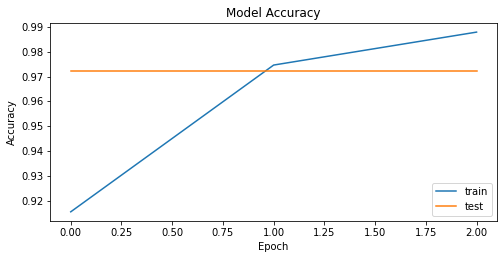

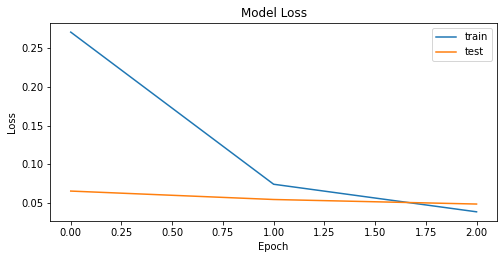

In [14]:
from matplotlib.ticker import StrMethodFormatter

plt.figure(figsize=(8, 8))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


# summarize history for accuracy  
plt.subplot(211)  
plt.plot(acc)  
plt.plot(val_acc)  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy') 
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places 
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='lower right')  

plt.figure(figsize=(8, 8)) 

# summarize history for loss     
plt.subplot(212)  
plt.plot(loss)  
plt.plot(val_loss)  
plt.title('Model Loss')  
plt.ylabel('Loss') 
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places 
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.show()

In [15]:
from keras.models import load_model
model.save('my_model.h5') # save the entire model with trained weights
new_model = load_model('my_model.h5') # load this model with its weights

# 7. Fine tuning

Fine-tuning is an optional step in transfer learning. Fine-tuning will usually improve the performance of the model. However, since you have to retrain the entire model, you’ll likely overfit. Overfitting is avoidable. Just retrain the model or part of it using a low learning rate. This is important because it prevents significant updates to the gradient. These updates result in poor performance. Using a callback to stop the training process when the model has stopped improving is also helpful. 

In the feature extraction experiment, you were only training a few layers on top of an Exception base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Also, you should try to fine-tune a small number of top layers rather than the whole Exception model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.





### Un-freeze the top layers of the model
All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.




In [16]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in new_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  133


###Compile the model
As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3078      
Total params: 21,913,646
Trainable params: 1,052,166
Non-trainable params: 20,861,480
_________________________________________________________________


In [19]:
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

#learning_rate reduce module
lr_reduce = keras.callbacks.ReduceLROnPlateau('val_loss', patience=4, 
                                              factor=0.5, min_lr=1e-6)

# Stop early if model doesn't improve after n epochs
early_stopper = EarlyStopping(monitor='val_loss', patience=4,
                              verbose=0, restore_best_weights=True)

In [20]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         batch_size = 32,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_generator,
                         callbacks=[lr_reduce, early_stopper],
                         verbose=1, shuffle=True)

Epoch 3/20
166/166 [==============================] - 21s 111ms/step - loss: 0.0507 - accuracy: 0.9850 - val_loss: 0.0307 - val_accuracy: 1.0000
Epoch 4/20
166/166 [==============================] - 16s 95ms/step - loss: 0.0466 - accuracy: 0.9869 - val_loss: 0.0291 - val_accuracy: 1.0000
Epoch 5/20
166/166 [==============================] - 16s 98ms/step - loss: 0.0426 - accuracy: 0.9851 - val_loss: 0.0259 - val_accuracy: 1.0000
Epoch 6/20
166/166 [==============================] - 16s 98ms/step - loss: 0.0400 - accuracy: 0.9854 - val_loss: 0.0240 - val_accuracy: 1.0000
Epoch 7/20
166/166 [==============================] - 18s 107ms/step - loss: 0.0215 - accuracy: 0.9939 - val_loss: 0.0237 - val_accuracy: 1.0000
Epoch 8/20
166/166 [==============================] - 16s 98ms/step - loss: 0.0309 - accuracy: 0.9868 - val_loss: 0.0243 - val_accuracy: 1.0000
Epoch 9/20
166/166 [==============================] - 17s 105ms/step - loss: 0.0227 - accuracy: 0.9931 - val_loss: 0.0248 - val_accura

In [21]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

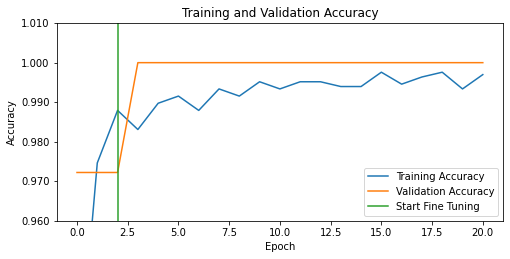

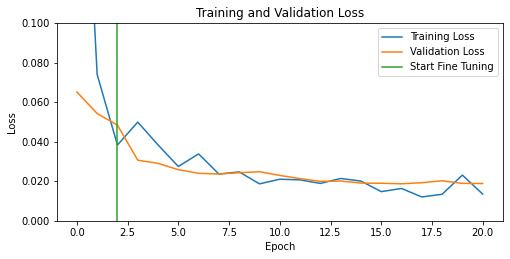

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.96, 1.01])
plt.plot([initial_epochs-8,initial_epochs-8],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy') 
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) # 3 decimal places 
plt.xlabel('Epoch')

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.1])
plt.plot([initial_epochs-8,initial_epochs-8],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel('Loss') 
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) # 3 decimal places 
plt.xlabel('Epoch')
plt.show()

In [23]:
# First, we are going to load the file names and their respective target labels into numpy array! 
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x_test, y_test,target_labels = load_dataset(test_dir)

In [24]:
no_of_classes = len(np.unique(y_test))
no_of_classes

6

In [25]:
y_test = np_utils.to_categorical(y_test,no_of_classes)

In [26]:
# We just have the file names in the x set. Let's load the images and convert them into array.
def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

Test set shape :  (72, 200, 200, 3)


In [27]:
x_test = x_test.astype('float32')/255

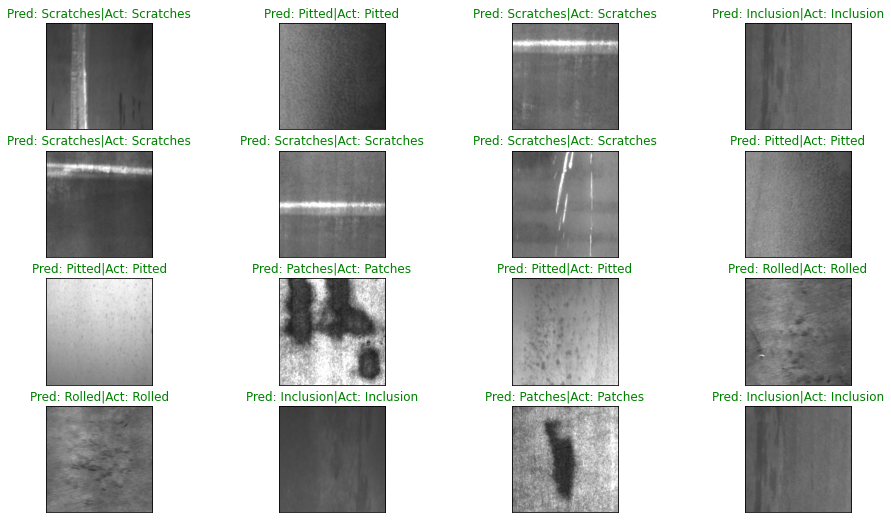

In [28]:
# Let's visualize test prediction.
y_pred = model.predict(x_test)

# plot a raandom sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("Pred: {}|Act: {}".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

We test our model with one sample metal defect product from one of metal company in Indonesia to predict the type of defect from this above picture. This sample already classified as scratch defect surface by quality control of its company.

In [29]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
 
# load the image
img = load_img('../input/test-data/Scracth.png', target_size=(200, 200))
# convert to array
img = img_to_array(img)
# reshape into a single sample with 3 channels
img = img.reshape(1, 200, 200, 3)
# center pixel data
img = img.astype('float32')/255
 
# predict the class
result = model.predict(img)
print('This metal has',target_labels[np.argmax(result)])

This metal has Scratches


The metal surface defect picture was predicted correctly by our model which the sample has been identified as scratches defect.